The Iris dataset contains 150 samples of iris flowers, each with four features: sepal
length, sepal width, petal length, and petal width. The dataset also includes the species of the iris
flowers, but we’ll ignore this information for clustering.
Use the Expectation-Maximization (EM) algorithm to fit a Gaussian Mixture Model (GMM) to
this data. Assume the data comes from a mixture of three Gaussian distributions. Perform the
following steps:

In [9]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load Iris dataset
iris = load_iris()
X = iris.data


## Preprocess the data by standardizing each feature.

In [10]:
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

Initialize the parameters of the GMM (means, variances, and mixing coefficients) randomly

In [11]:
np.random.seed(42)
n_samples, n_features = X_standardized.shape
n_components = 3  # Assume three clusters

# Initialize means randomly
means = np.random.rand(n_components, n_features)

# Initialize covariances as identity matrices
covariances = np.array([np.eye(n_features) for _ in range(n_components)])

# Initialize mixing coefficients uniformly
mixing_coefficients = np.full(n_components, 1 / n_components)


## Implement the EM algorithm to fit the GMM to the data.

In [12]:
def e_step(X, means, covariances, mixing_coefficients):
    responsibilities = np.zeros((n_samples, n_components))
    
    for i in range(n_components):
        # Multivariate Gaussian density function
        cov_det = np.linalg.det(covariances[i])
        cov_inv = np.linalg.inv(covariances[i])
        factor = 1.0 / np.sqrt((2 * np.pi) ** n_features * cov_det)
        diff = X - means[i]
        responsibilities[:, i] = mixing_coefficients[i] * factor * \
            np.exp(-0.5 * np.sum(diff @ cov_inv * diff, axis=1))
    
    # Normalize responsibilities
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)
    return responsibilities

def m_step(X, responsibilities):
    N_k = responsibilities.sum(axis=0)
    means = np.dot(responsibilities.T, X) / N_k[:, np.newaxis]
    covariances = np.zeros((n_components, n_features, n_features))
    
    for i in range(n_components):
        diff = X - means[i]
        covariances[i] = np.dot(responsibilities[:, i] * diff.T, diff) / N_k[i]
        
    mixing_coefficients = N_k / n_samples
    return means, covariances, mixing_coefficients


## Perform the EM algorithm for a maximum of 100 iterations or until convergence.

In [16]:
def run_em(X, max_iters=100, tol=1e-6):
    np.random.seed(42)
    n_samples, n_features = X.shape
    n_components = 3  # Assume three clusters

    # Initialize means, covariances, and mixing coefficients within the function
    means = np.random.rand(n_components, n_features)
    covariances = np.array([np.eye(n_features) for _ in range(n_components)])
    mixing_coefficients = np.full(n_components, 1 / n_components)

    log_likelihoods = []
    
    for _ in range(max_iters):
        # E-step
        responsibilities = e_step(X, means, covariances, mixing_coefficients)
        
        # M-step
        means, covariances, mixing_coefficients = m_step(X, responsibilities)
        
        # Log-likelihood
        log_likelihood = np.sum(np.log(responsibilities.sum(axis=1)))
        log_likelihoods.append(log_likelihood)
        
        # Check for convergence
        if len(log_likelihoods) > 1 and np.abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    
    return means, covariances, mixing_coefficients, responsibilities

# Run the EM algorithm
means, covariances, mixing_coefficients, responsibilities = run_em(X_standardized)


## Report the final parameters (means, variances, and mixing coefficients).

In [17]:
print("Final means:", means)
print("Final covariances:", covariances)
print("Final mixing coefficients:", mixing_coefficients)


Final means: [[ 0.26282745  0.25812413  0.16291265  0.15834994]
 [-0.25427111 -0.24487732 -0.14699395 -0.15756411]
 [ 0.18198345  0.17037244  0.09449246  0.1171788 ]]
Final covariances: [[[ 1.12385659 -0.17573175  0.98109892  0.89110328]
  [-0.17573175  0.97095789 -0.48267968 -0.42380037]
  [ 0.98109892 -0.48267968  1.10950135  1.05206475]
  [ 0.89110328 -0.42380037  1.05206475  1.09180461]]

 [[ 0.78404165 -0.14158991  0.70789492  0.668217  ]
  [-0.14158991  0.95172979 -0.42327875 -0.3644827 ]
  [ 0.70789492 -0.42327875  0.85852405  0.82518255]
  [ 0.668217   -0.3644827   0.82518255  0.84381521]]

 [[ 1.03949948 -0.22399197  0.92416591  0.87370429]
  [-0.22399197  0.91410728 -0.50362916 -0.4390733 ]
  [ 0.92416591 -0.50362916  1.0650104   1.03705593]
  [ 0.87370429 -0.4390733   1.03705593  1.09873416]]]
Final mixing coefficients: [0.26377988 0.46603174 0.27018838]


## Visualize the clustering results on the first two principal components of the data.

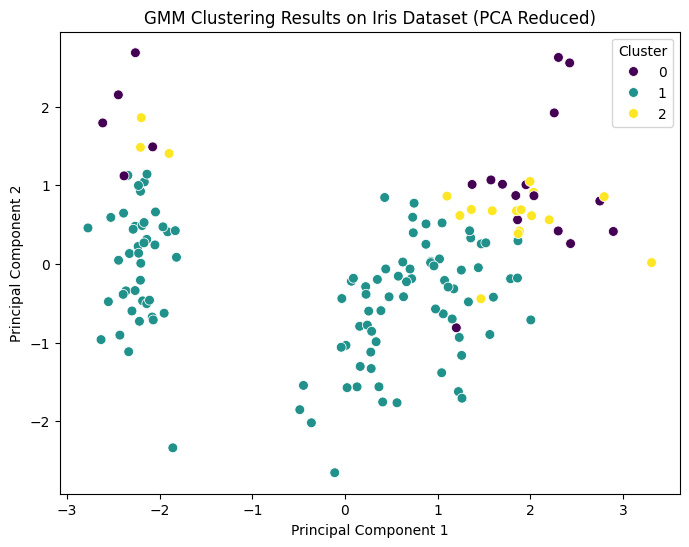

In [18]:
# Perform PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

# Assign cluster labels based on maximum responsibility
cluster_labels = np.argmax(responsibilities, axis=1)

# Plot the clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, palette="viridis", s=50)
plt.title("GMM Clustering Results on Iris Dataset (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()